In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import requests, zipfile, StringIO
import urllib2
import urllib
import json
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import matplotlib.pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Reading zipfiles in a dictionary
dic={}
for i in range (94,100):
    fname = 'zbp{0}totals.zip'.format(i)
    zf = zipfile.ZipFile(fname)
    dic[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
        
for i in range (0,10):
    fname = 'zbp0{0}totals.zip'.format(i)
    zf = zipfile.ZipFile(fname)
    dic[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
                
for i in range (10,14):
    fname = 'zbp{0}totals.zip'.format(i)
    zf = zipfile.ZipFile(fname)
    dic[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt'))) 

In [3]:
dic.keys()

[96, 97, 98, 99, 4, 5, 0, 1, 8, 9, 10, 7, 12, 2, 13, 11, 3, 6, 94, 95]

In [4]:
# Download NYC map with zip codes
url = 'https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson'
fname = 'nyc-zip-code-tabulation-areas-polygons.geojson'
urllib.urlretrieve(url, fname)

('nyc-zip-code-tabulation-areas-polygons.geojson',
 <httplib.HTTPMessage instance at 0x0000000011198788>)

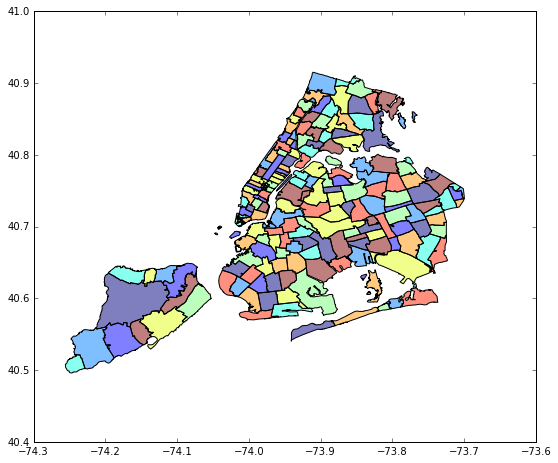

In [5]:
# Read the file as a geodataframe and plot it
nyc = gp.read_file(fname)
nyc.plot(figsize=(9,9))

### Figure 1
Shows the map of NYC broken down by zip code.

In [6]:
zipcodes = nyc.postalCode

In [7]:
index = dic.keys()

In [8]:
# Make all columns have the same format (lower case)
for i in index:
    temp_val = [x.lower() for x in (dic[i].columns.tolist())]
    dic[i].columns = temp_val

In [9]:
index

[96, 97, 98, 99, 4, 5, 0, 1, 8, 9, 10, 7, 12, 2, 13, 11, 3, 6, 94, 95]

In [10]:
foo = range(1996, 2000) + range(2004,2006) + range(2000,2002) + range(2008,2011) + [2007, 2012, 2002, 2013, 2011, 2003, 2006] + range(1994,1996)
dic_new = {}
for counter, i in enumerate(index):
    dic_new[i] = dic[i][['zip', 'est']]
    dic_new[i]['year'] = foo[counter]

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
df = pd.DataFrame(dic_new[0])

for indx in index[1:]:
    df_tmp = pd.DataFrame(dic_new[indx])
    df = np.concatenate((df_tmp, df), axis=0)
data = pd.DataFrame(df, columns = ['zip_code','est','year'])

In [12]:
data.shape

(789753, 3)

In [13]:
data.head()

,zip_code,est,year
0,501,2,1995
1,1000,4,1995
2,1001,439,1995
3,1002,467,1995
4,1003,10,1995


In [14]:
# Isolate NYC zip codes
data['zip_code'] = data['zip_code'].astype(str)
table = data['zip_code'].isin(zipcodes)
data = data[table]

In [15]:
data.head()

,zip_code,est,year
3010,10001,7088,1995
3011,10002,1819,1995
3012,10003,3377,1995
3013,10004,1124,1995
3014,10005,1109,1995


In [16]:
# Group data to create time series
df_group = data.groupby(['zip_code', 'year']).mean().unstack()

In [17]:
df_group.head()

est                                                          \
year        1994    1995    1997    1998    1999    2000    2001    2002   
zip_code                                                                   
10001     6999.0  7088.0  7154.0  7254.0  7233.0  7317.0  7188.0  7141.0   
10002     1784.0  1819.0  2049.0  2003.0  2085.0  2277.0  2543.0  2269.0   
10003     3256.0  3377.0  3535.0  3649.0  3659.0  3683.0  3602.0  3616.0   
10004     1115.0  1124.0  1173.0  1176.0  1233.0  1294.0  1247.0  1253.0   
10005     1076.0  1109.0  1227.0  1270.0  1242.0  1287.0  1249.0  1244.0   

                                                                          \
year        2003    2004    2005    2006    2007    2008    2009    2010   
zip_code                                                                   
10001     7084.0  7370.0  7312.0  7415.0  7549.0  7472.0  7305.0  7241.0   
10002     2402.0  2551.0  2682.0  2686.0  2685.0  2691.0  2775.0  2872.0   
10003     3704.0  3776.0  3867.0  3909.0  4049.0  4071.0  4099.0  4113.0   
10004     1252.0  1283.0  1260.0  1311.0  1370.0  1376.0  1379.0  1398.0   
10005     1200.0  1226.0  1214.0  1259.0  1273.0  1291.0  1274.0  1266.0   

                                  
year        2011    2012    2013  
zip_code                          
10001     7227.0  7235.0  7273.0  
10002     2912.0  2954.0  2988.0  
10003     4159.0  4214.0  4277.0  
10004     1404.0  1442.0  1479.0  
10005     1301.0  1273.0  1296.0

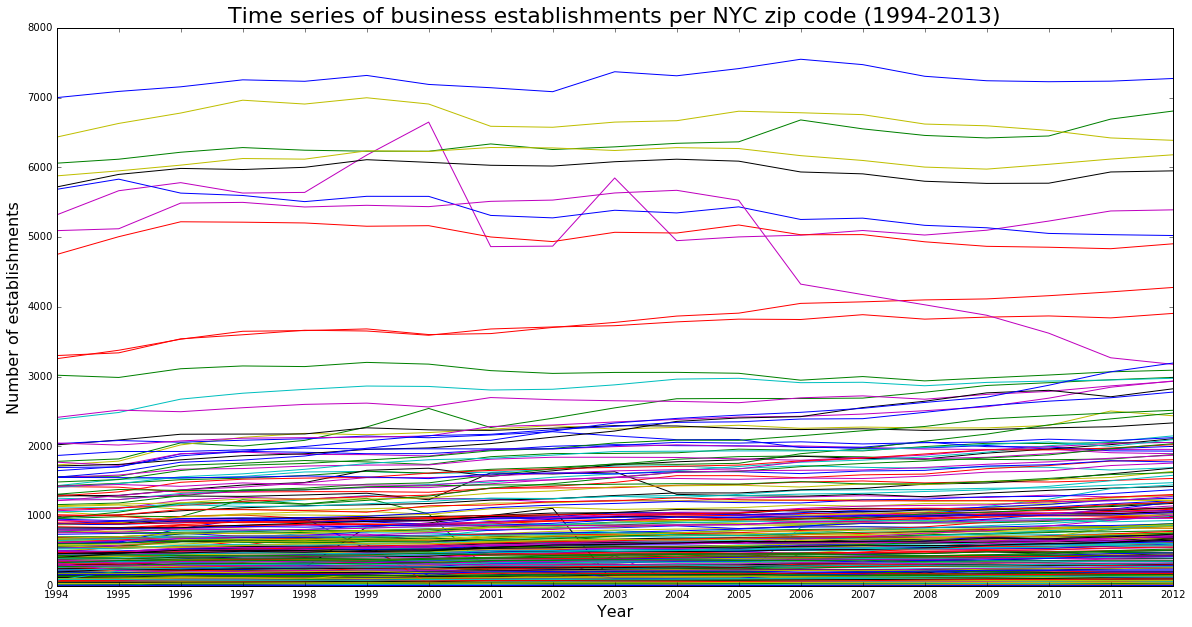

In [18]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0,20), sort(foo))
for i in range(len(df_group)):
    plt.plot(df_group.iloc[i,:].values) 
plt.title('Time series of business establishments per NYC zip code (1994-2013)', size=22)
plt.xlabel('Year', size=16)
plt.ylabel('Number of establishments', size=16)

### Figure 2
Shows the time series of new business establishments for all NYC zipcodes from 1994-2013. Notice that the magnitude of establishments per zip code differs significantly, so in the next step we will standardize the time series. 

In [19]:
# An attempt to standardize the data with sklearn's StandardScaler. I couldnt figure out why its not working.

# df_norm = df_group
# for i in range(len(df_norm)):
#     scaler = StandardScaler()
#     df_norm.iloc[i] = scaler.fit_transform(df_norm.iloc[i].dropna())

In [20]:
df_norm = df_group
for i in range(0,len(df_norm)):
    df_norm.iloc[i] = (df_group.iloc[i]-df_group.iloc[i].mean())/df_group.iloc[i].std()

df_norm.head()

est                                                    \
year          1994      1995      1997      1998      1999      2000   
zip_code                                                               
10001    -1.882624 -1.229729 -0.745559 -0.011969 -0.166023  0.450193   
10002    -1.794134 -1.703273 -1.106185 -1.225602 -1.012727 -0.514288   
10003    -1.933108 -1.519731 -0.979949 -0.590487 -0.556324 -0.474331   
10004    -1.693037 -1.607484 -1.141699 -1.113182 -0.571350  0.008505   
10005    -2.771399 -2.216765 -0.233530  0.489174  0.018576  0.774895   

                                                                      \
year          2001      2002      2003      2004      2005      2006   
zip_code                                                               
10001    -0.496139 -0.840926 -1.259072  0.838995  0.413513  1.169111   
10002     0.176257 -0.535057 -0.189784  0.197025  0.537106  0.547490   
10003    -0.751055 -0.703226 -0.402588 -0.156612  0.154275  0.297761   
10004    -0.438268 -0.381233 -0.390739 -0.096059 -0.314693  0.170104   
10005     0.136226  0.052190 -0.687321 -0.250337 -0.452022  0.304297   

                                                                                
year          2007      2008      2009      2010      2011      2012      2013  
zip_code                                                                        
10001     2.152122  1.587257  0.362162 -0.107336 -0.210038 -0.151351  0.127413  
10002     0.544894  0.560471  0.778538  1.030353  1.134194  1.243228  1.331493  
10003     0.776048  0.851207  0.946865  0.994694  1.151845  1.339744  1.554973  
10004     0.730948  0.787983  0.816500  0.997111  1.054146  1.415367  1.767082  
10005     0.539596  0.842123  0.556403  0.421946  1.010194  0.539596  0.926159

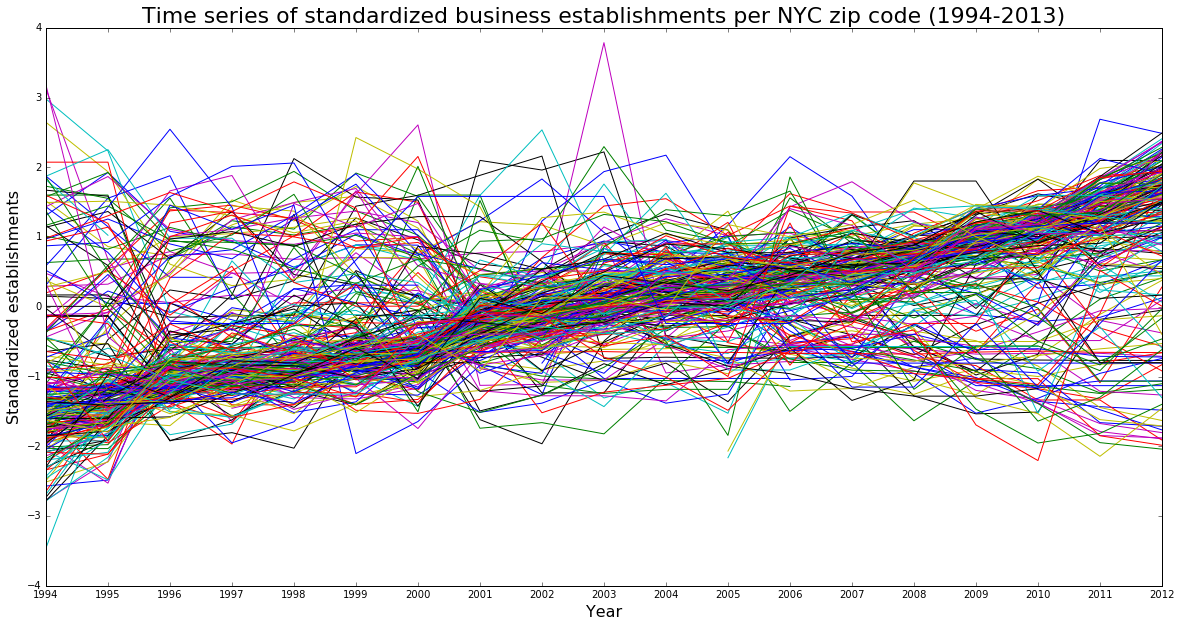

In [21]:
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0,20), sort(foo))
for i in range(len(df_norm)):
    plt.plot(df_norm.iloc[i,:].values)  
plt.title('Time series of standardized business establishments per NYC zip code (1994-2013)', size=22)
plt.xlabel('Year', size=16)
plt.ylabel('Standardized establishments', size=16)

### Figure 3
Shows the standardized time series of new business establishments for all NYC zipcodes from 1994-2013. We can observe an obvious increasing trend in several zipcodes.

# Clustering

In [22]:
df_norm = df_norm.dropna()

In [23]:
# Selecting optimal number of clusters based on Silhouette score
range_n_clusters = np.arange(2,8,1)
for clusters in range_n_clusters:
    km = KMeans(n_clusters = clusters, random_state = 25)
    cluster_labels = km.fit_predict(df_norm)
    silhouette_sc = silhouette_score(df_norm, cluster_labels)
    print("For n_clusters = {},".format(clusters)+" the average silhouette score is :{}".format(silhouette_sc))

For n_clusters = 2, the average silhouette score is :0.56003168242
For n_clusters = 3, the average silhouette score is :0.515690069768
For n_clusters = 4, the average silhouette score is :0.447504612422
For n_clusters = 5, the average silhouette score is :0.288245925583
For n_clusters = 6, the average silhouette score is :0.284855084327
For n_clusters = 7, the average silhouette score is :0.160366170934


From the Silhouette score obtained above, we observe that __2__ is the optimal number of clusters.

In [24]:
km = KMeans(n_clusters = 2, random_state = 25)
cluster_labels = km.fit_predict(df_norm)

In [25]:
df_norm['label'] = cluster_labels

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
df_norm.head()

est                                                    \
year          1994      1995      1997      1998      1999      2000   
zip_code                                                               
10001    -1.882624 -1.229729 -0.745559 -0.011969 -0.166023  0.450193   
10002    -1.794134 -1.703273 -1.106185 -1.225602 -1.012727 -0.514288   
10003    -1.933108 -1.519731 -0.979949 -0.590487 -0.556324 -0.474331   
10004    -1.693037 -1.607484 -1.141699 -1.113182 -0.571350  0.008505   
10005    -2.771399 -2.216765 -0.233530  0.489174  0.018576  0.774895   

                                                                      \
year          2001      2002      2003      2004      2005      2006   
zip_code                                                               
10001    -0.496139 -0.840926 -1.259072  0.838995  0.413513  1.169111   
10002     0.176257 -0.535057 -0.189784  0.197025  0.537106  0.547490   
10003    -0.751055 -0.703226 -0.402588 -0.156612  0.154275  0.297761   
10004    -0.438268 -0.381233 -0.390739 -0.096059 -0.314693  0.170104   
10005     0.136226  0.052190 -0.687321 -0.250337 -0.452022  0.304297   

                                                                      \
year          2007      2008      2009      2010      2011      2012   
zip_code                                                               
10001     2.152122  1.587257  0.362162 -0.107336 -0.210038 -0.151351   
10002     0.544894  0.560471  0.778538  1.030353  1.134194  1.243228   
10003     0.776048  0.851207  0.946865  0.994694  1.151845  1.339744   
10004     0.730948  0.787983  0.816500  0.997111  1.054146  1.415367   
10005     0.539596  0.842123  0.556403  0.421946  1.010194  0.539596   

                   label  
year          2013        
zip_code                  
10001     0.127413     0  
10002     1.331493     0  
10003     1.554973     0  
10004     1.767082     0  
10005     0.926159     0

In [27]:
df_low = df_norm[df_norm.label==0]
df_high = df_norm[df_norm.label==1]

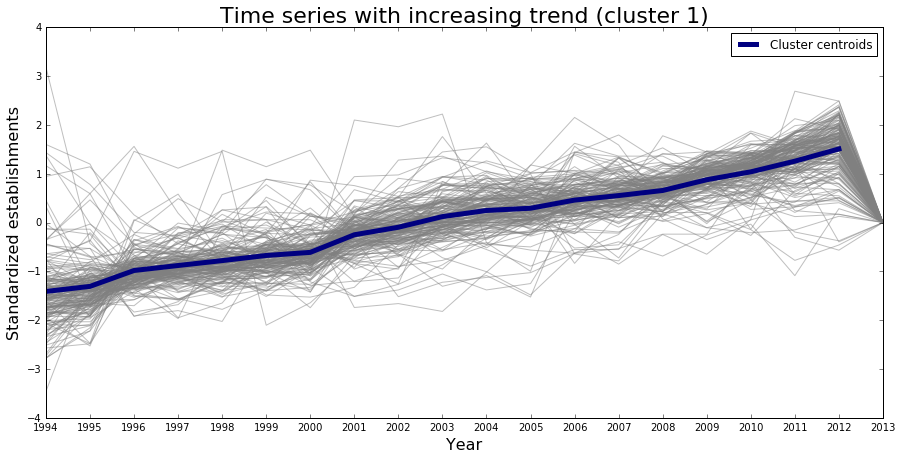

In [28]:
plt.figure(figsize=(15,7))
plt.xticks(np.arange(0,20), sort(foo))
for i in range(len(df_low)):
    plt.plot(df_low.iloc[i,:].values, alpha=0.5, color='gray') 
plt.plot(km.cluster_centers_[0], linewidth=5, color='navy', label='Cluster centroids')
plt.title('Time series with increasing trend (cluster 1)', size=22)
plt.xlabel('Year', size=16)
plt.ylabel('Standardized establishments', size=16)
plt.legend()

### Figure 4
Shows the time series of zip codes in the first cluster. Those areas show an increasing number of business establishments over time. 

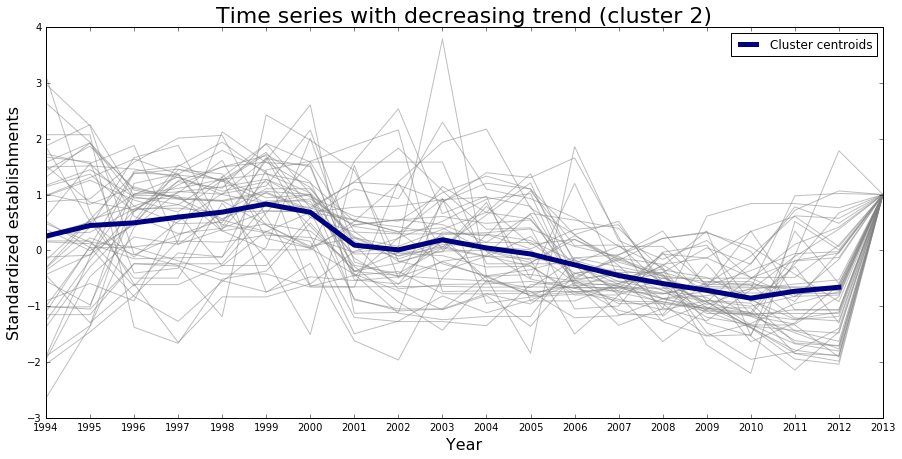

In [29]:
plt.figure(figsize=(15,7))
plt.xticks(np.arange(0,20), sort(foo))
for i in range(len(df_high)):
    plt.plot(df_high.iloc[i,:].values, alpha=0.5, color='grey')
plt.plot(km.cluster_centers_[1], linewidth=5, color='navy', label='Cluster centroids')
plt.title('Time series with decreasing trend (cluster 2)', size=22)
plt.xlabel('Year', size=16)
plt.ylabel('Standardized establishments', size=16)
plt.legend()

### Figure 5
Shows the time series of zip codes in the second cluster. Those areas show an increasing number of business establishments over time until 2000, and then the number keeps decreasing up to 2013.

In [30]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    '''
    Function that calculates and plots the 'elbow' for kmeans clustering. Developed in ADS's class session 7.
    Inputs: data, number of clusters K
    Outputs: Elbow plot
    '''
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

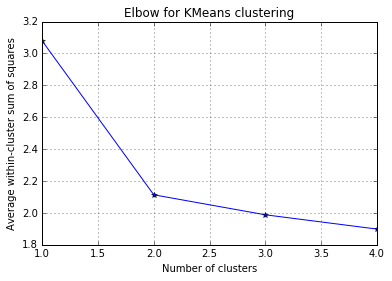

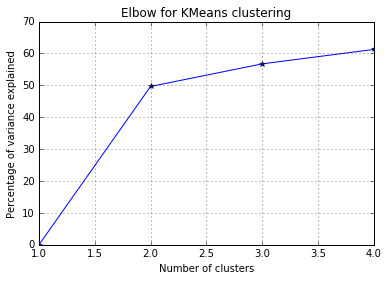

In [31]:
elbow(df_norm, range(1,5))

### Figure 6
Shows the elbow method for cluster selection. We can visually validate the previous findings based on the Silhouette scores.

In [32]:
postalCode = df_norm.index.tolist()
df_map = pd.DataFrame({'postalCode':postalCode, 'label':cluster_labels})

In [33]:
df_map_clust = pd.merge(nyc, df_map, on='postalCode')

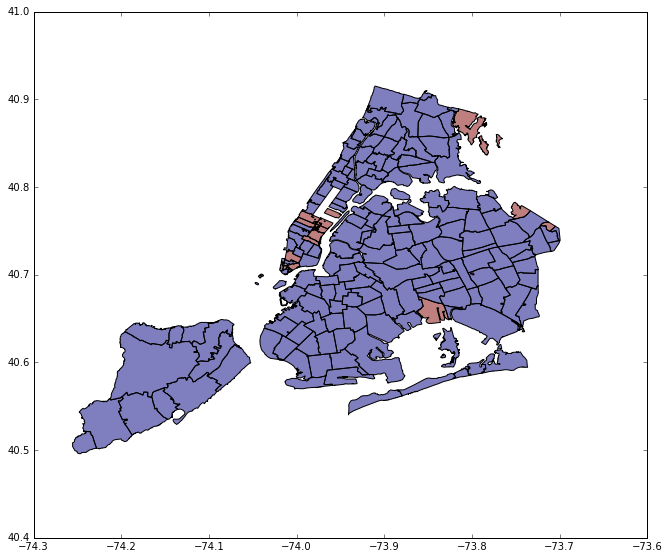

In [34]:
df_map_clust.plot(column = 'label', figsize=(11,11))

### Figure 7
Shows NYC's zipcodes clustered based on the evolution of business establishments, using KMeans clustering algorithm. The red regions represent the areas of decreasing trend in business establishments. It is no surprise that most of the "red" zip codes are located in Manhattan. Manhattan is a commercial area with vivid business activity, making it less easier for new businesses to get established in the area. Up to 2000, the time series of the red zip codes shown a slight increase, but after this threshold it keeps decreasing till 2013, as shown in Figure 5. The steep decrease in the year of 2001 could be potentially attributed to the fear of terrorist attacks, following the incidents of 9/11. 

On the other hand, areas like Brooklyn and Queens show a constant increase in their business establishments, as shown in Figure 4. During the 90s those areas experienced significant development and economic growth, fact that is also supported by the analysis. 

In [35]:
# Let's try Agglomerative Clustering algorithm too
range_n_clusters = np.arange(2,8,1)
for clusters in range_n_clusters:
    agg = AgglomerativeClustering(n_clusters = clusters)
    cluster_labels = agg.fit_predict(df_norm)
    silhouette_sc = silhouette_score(df_norm, cluster_labels)
    print("For n_clusters = {},".format(clusters)+" the average silhouette score is :{}".format(silhouette_sc))

For n_clusters = 2, the average silhouette score is :0.553269372976
For n_clusters = 3, the average silhouette score is :0.481222363966
For n_clusters = 4, the average silhouette score is :0.464608352645
For n_clusters = 5, the average silhouette score is :0.325572157372
For n_clusters = 6, the average silhouette score is :0.323807917413
For n_clusters = 7, the average silhouette score is :0.119157560142


The Silhouette score analysis for the Agglomerative Clustering algorithm agrees with the findings of KMeans, suggesting __2__ as the optimal number of clusters.

In [36]:
agg = AgglomerativeClustering(n_clusters = 2)
cluster_labels = agg.fit_predict(df_norm)

In [37]:
postalCode = df_norm.index.tolist()
df_map = pd.DataFrame({'postalCode':postalCode, 'label':cluster_labels})

In [38]:
df_map_clust = pd.merge(nyc, df_map, on='postalCode')

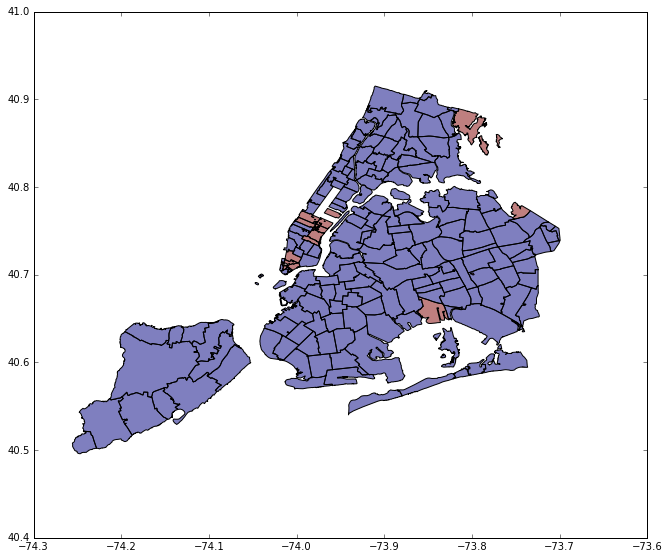

In [39]:
df_map_clust.plot(column = 'label', figsize=(11,11))

### Figure 8
Shows the result depicted in Figure 5, but using Agglomerative clustering algorithm. The results are in general consistant, with the majority of zip codes showing decreasing trend in business establishments for the time horizon 1994-2013 being mostly located in Manhattan.